In [1]:
import torch
import numpy as np
from diffusers.training_utils import compute_snr
from diffusers import DDPMScheduler
import pickle
from torch.optim import AdamW
import torch.nn.functional as F
import sys
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append("edm")
from edm.torch_utils import misc
from edm.dnnlib import util
from edm.training.networks import EDMPrecond
from edm import generate
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda")
NUM_CLASSES = 10

In [2]:
with open("edm-cifar10-32x32-cond-ve.pkl", 'rb') as f:
    mu_real = pickle.load(f)['ema'].train().to(DEVICE)
with open("edm-cifar10-32x32-cond-ve.pkl", 'rb') as f:  
    G = pickle.load(f)['ema'].train().to(DEVICE)
with open("edm-cifar10-32x32-cond-ve.pkl", 'rb') as f:
    mu_fake = pickle.load(f)['ema'].train().to(DEVICE)


for param in G.model.parameters():
    param.requires_grad = True
for param in mu_real.model.parameters():
    param.requires_grad = True
for param in mu_fake.model.parameters():
    param.requires_grad = True

In [3]:
BATCH_SIZE = 32
T = 100
lambda_reg = 0.25 #TODO: for uncond training -- 0.5
const_timestep_G = torch.tensor([100] * BATCH_SIZE, device=DEVICE) # Из пдф с проектами: 

In [4]:
def distribution_matching_loss(mu_real, mu_fake, 
                               x, #generated output of our generator
                               class_labels,
                               t_min=int(0.02 * T), t_max=int(0.98 * T) #timestep intervals for computing distribution matching loss
                               ): 
    timestep = torch.rand(x.shape[0], device=DEVICE) * (t_max - t_min) + t_min
    noise = torch.randn_like(x) * timestep[:, None, None, None]
    noised_x = x + noise
    with torch.no_grad():
        pred_fake_x = mu_fake(noised_x, timestep, class_labels)
        pred_real_x = mu_real(noised_x, timestep, class_labels)
    weighting_factor = 1
    grad = (pred_fake_x - pred_real_x) / weighting_factor
    loss = 0.5 * F.mse_loss(x, (x - grad).detach())
    return loss


def denoising_loss(pred_x, #denoised output by mu_fake on x_t, mu_fake(x_t)
                   timestep,
                   x #fake sample generated by our one-step generator
                   ):
    weight =  1
    loss = F.mse_loss(pred_x, x, reduction="mean")
    return loss


def lpips_loss(fake_ref, #G(z), z from dataset D
               real_ref, #y from dataset D
               ):
    # ups = nn.Upsample((224, 224), mode="bilinear")
    # fake_ref_ups = ups(fake_ref)
    # real_ref_ups = ups(real_ref)
    loss = lpips(fake_ref, real_ref) #TODO: Вроде в статье написано "Prior to input into the LPIPS network, 
    #images are upscaled to a resolution of 224×224 using bilinear upsampling.", при этому в открытом гитхаб
    #репозитории никто не заморачивается + абсолютно спокойно работает и так
    return loss

In [5]:
def train_step(batch, optimizer_G, optimizer_mu_fake):
    #TODO: add learning rate scheduler
    optimizer_G.zero_grad()
    optimizer_mu_fake.zero_grad()
    
    z_ref, y_ref, class_labels = batch
    bs = z_ref.shape[0]
    z = torch.randn_like(z_ref) * T
    x, x_ref = G(z, const_timestep_G, class_labels=class_labels), G(z_ref, const_timestep_G, class_labels=class_labels)
    # update generator
    loss_kl = distribution_matching_loss(mu_real, mu_fake, x, class_labels=class_labels)
    # loss_reg = lpips_loss(x_ref, y_ref)
    # loss_G = loss_kl + lambda_reg * loss_reg
    loss_G = loss_kl
    torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=10)
    loss_G.backward()
    optimizer_G.step() 
    linear_warmup_G.step() #добавили шедулер

    #update mu_fake
    timestep = torch.rand(bs, device=z_ref.device) * T
    noise = torch.randn_like(x) * timestep[:, None, None, None]
    xt = x.detach() + noise.detach() #noised x
    pred_x = mu_fake(xt, timestep, class_labels=class_labels) #pred noise
    loss_denoise = denoising_loss(pred_x, timestep, x.detach()) #не x.detach, а noise (noise.detach())?
    torch.nn.utils.clip_grad_norm_(mu_fake.parameters(), max_norm=10)
    loss_denoise.backward()
    optimizer_mu_fake.step()
    linear_warmup_mu_fake.step() #добавили шедулер
    
    return loss_G, loss_denoise

In [6]:
optimizer_G = AdamW(G.parameters(), lr=5e-5)
optimizer_mu_fake = AdamW(mu_fake.parameters(), lr=5e-5)

linear_warmup_G = torch.optim.lr_scheduler.LinearLR(optimizer_G, start_factor=0.01, total_iters=500)
linear_warmup_mu_fake = torch.optim.lr_scheduler.LinearLR(optimizer_mu_fake, start_factor=0.01, total_iters=500)

### Обучаемся как на батче

In [7]:
noise_dataset = torch.load("dataset/noise.pt")
class_labels_dataset = torch.load("dataset/class_labels.pt")
y_dataset = torch.load("dataset/y.pt")

In [8]:
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(noise_dataset, y_dataset, class_labels_dataset)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
def plot_losses(loss_history_G, loss_history_mu_fake):
    f, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(loss_history_G)
    axs[0].grid(True)
    axs[0].set_title("loss G")

    axs[1].plot(loss_history_mu_fake)
    axs[1].grid(True)
    axs[1].set_title("loss mu_fake")
    plt.show()

Step 5000:
Loss G: 0.00148783007171005
Loss mu_fake: 0.1760503500699997
----------------------------


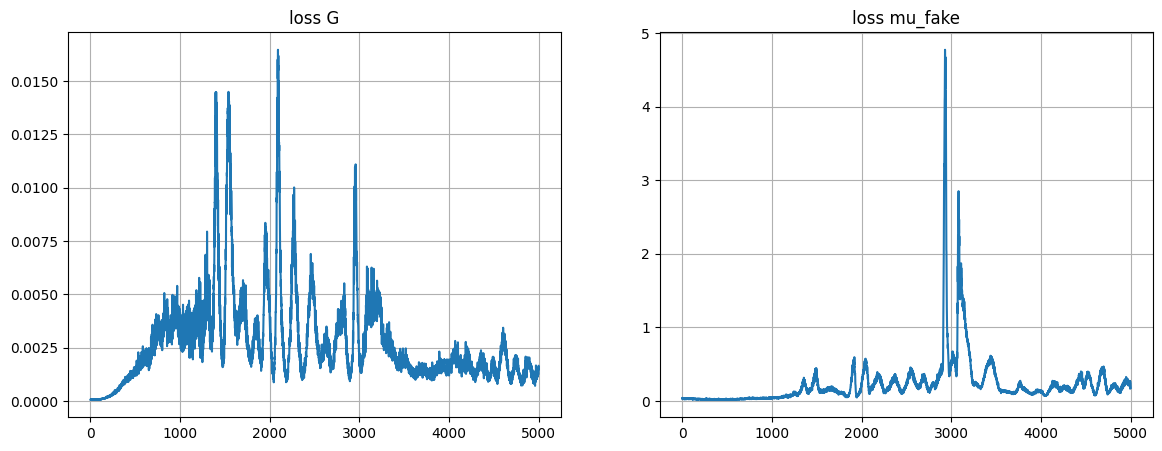

100%|██████████| 5001/5001 [2:27:19<00:00,  1.77s/it]


In [10]:
from IPython.display import clear_output
loss_history_G = []
loss_history_mu_fake = []

optimizer_G = AdamW(G.parameters(), lr=1e-5)
optimizer_mu_fake = AdamW(mu_fake.parameters(), lr=1e-5)

linear_warmup_G = torch.optim.lr_scheduler.LinearLR(optimizer_G, start_factor=0.01, total_iters=500)
linear_warmup_mu_fake = torch.optim.lr_scheduler.LinearLR(optimizer_mu_fake, start_factor=0.01, total_iters=500)
    
data_iter = iter(dataloader) 
for step in tqdm(range(5001)):    
    try:
        batch = next(data_iter) 
    except StopIteration:
        data_iter = iter(dataloader)
        batch = next(data_iter)
    batch[0] = (batch[0] * T).to(DEVICE)
    batch[1] = batch[1].float().to(DEVICE)
    batch[2] = batch[2].to(DEVICE)
    loss_G, loss_mu_fake = train_step(batch, optimizer_G, optimizer_mu_fake)
    loss_history_G.append(loss_G.detach().cpu())
    loss_history_mu_fake.append(loss_mu_fake.detach().cpu())
    if step % 100 == 0:
        clear_output(wait=True)
        print(f"Step {step}:")
        print(f"Loss G: {loss_G}")
        print(f"Loss mu_fake: {loss_mu_fake}")
        print("----------------------------")
        plot_losses(loss_history_G, loss_history_mu_fake)
    if step % 5000 == 0:
        torch.save({
            'step': step,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'loss': loss_G,
        }, f"model_weights_without_lpips/model_G_{step}steps.pt")
        torch.save({
            'step': step,
            'model_state_dict': mu_fake.state_dict(),
            'optimizer_state_dict': optimizer_mu_fake.state_dict(),
            'loss': loss_mu_fake,
        }, f"model_weights_without_lpips/model_mu_fake_{step}steps.pt")

Step 5000:
Loss G: 0.00148783007171005
Loss mu_fake: 0.1760503500699997
----------------------------


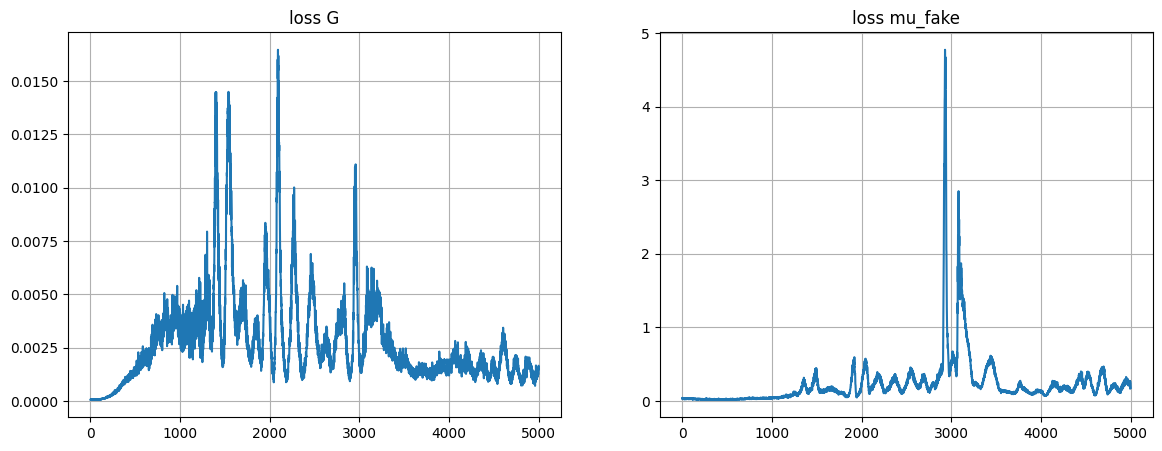

In [11]:
print(f"Step {step}:")
print(f"Loss G: {loss_G}")
print(f"Loss mu_fake: {loss_mu_fake}")
print("----------------------------")
plot_losses(loss_history_G, loss_history_mu_fake)

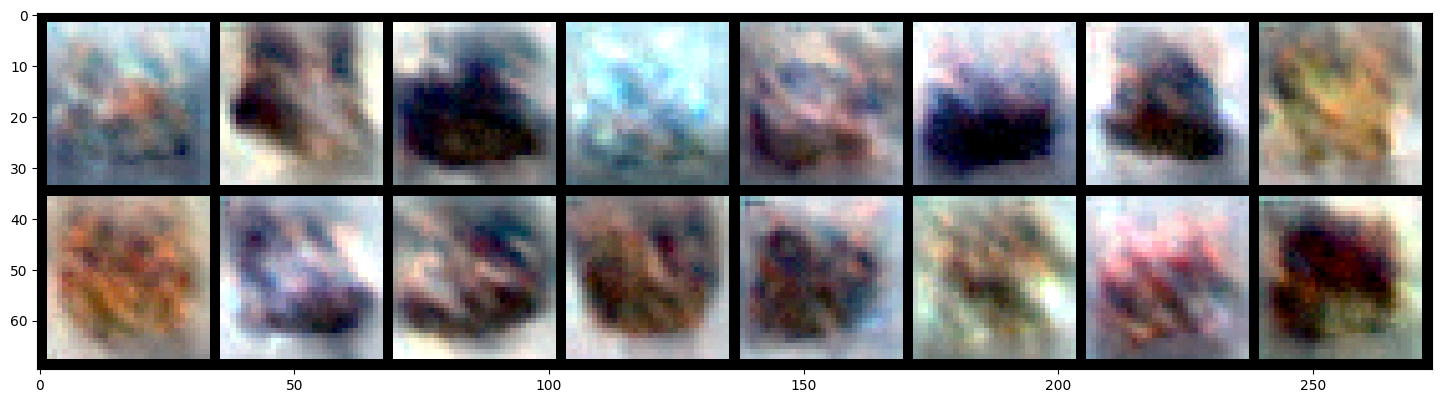

In [12]:
from torchvision.utils import make_grid
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

class_labels = torch.zeros(BATCH_SIZE, NUM_CLASSES, device=DEVICE).long()
class_labels[np.arange(BATCH_SIZE), np.random.randint(0, NUM_CLASSES, size=BATCH_SIZE)] = 1
z_random = torch.randn(BATCH_SIZE, 3, 32, 32, device=DEVICE)
plt.figure(figsize=[18, 10])
out = G(z_random * T, const_timestep_G, class_labels=class_labels)
norm_factor = out.abs().max(dim=(0)).values[None, ...]
plt.imshow(make_grid((normalize(out)[:16] + 1) / 2).cpu().permute(1, 2, 0).detach().numpy())